In [48]:
from b2heavy.TwoPointFunctions.types2pts  import CorrelatorIO, Correlator
from b2heavy.TwoPointFunctions.fitter     import CorrFitter
from b2heavy.TwoPointFunctions.utils      import NplusN2ptModel, PeriodicExpDecay

In [64]:
import itertools
import numpy             as np
import autograd.numpy    as anp
import xarray            as xr
import gvar              as gv
import pyerrors          as pyr
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

In [50]:
ens = 'Coarse-1'
mes = 'Dst'
mom = '200'
binsize = 11

data_dir = '/Users/pietro/code/data_analysis/BtoD/Alex/'

# New structure

In [102]:
class CorrObs(Correlator):
    def __init__(self, io:CorrelatorIO, smearing=None, polarization=None, **kwargs):
        super().__init__(io,jkBin=0)

        SMR = smearing     if not smearing==None     else list(self.data.smearing.values)
        POL = polarization if not polarization==None else list(self.data.polarization.values)

        self.smearing = SMR
        self.polarization = POL 
        self.keys = sorted([(smr,pol) for smr in SMR for pol in POL])

        xd = {}
        for (smr,pol) in self.keys:
            # xd[smr,pol] = pyr.Corr(
            #     [
            #         pyr.Obs([self.data.loc[smr,pol,:,t].to_numpy()],[ens]) 
            #         for t in self.data.timeslice
            #     ]
            xd[smr,pol] = [
                pyr.Obs([self.data.loc[smr,pol,:,t].to_numpy()],[ens]) 
                for t in self.data.timeslice
            ]

        self.pycorr = xd
        return

In [103]:
io = CorrelatorIO(ens,mes,mom,PathToDataDir=data_dir)
self = CorrObs(io,smearing=['d-d','1S-1S','d-1S'])

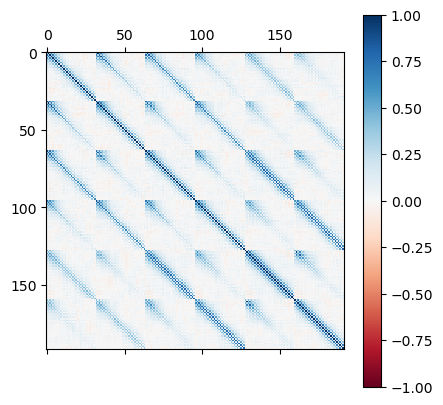

In [130]:
cc = np.concatenate([self.pycorr[sm,pol] for (sm,pol) in self.keys])
for c in cc:
    c.gamma_method(S=5.)

cov = pyr.covariance(cc,visualize=True)

In [139]:
l,v = np.linalg.eigh(cov)
covn = pyr.covariance(cc,smooth=len(l[l>1e-13]))

# New fit

In [230]:
Nstates = 3
Nt      = self.Nt
Npol    = len(self.polarization)

def model_single(p,t):
    rlen = 2*Nstates
    ans  = anp.exp(p[rlen  ])**2   * ( anp.exp(-p[0] * t) + anp.exp(-p[0] * (Nt-t)) )

    erg = [p[0]]
    for n in range(1,2*Nstates):
        En = anp.exp(p[n]) + erg[n - (1 if n==1 else 2)]
        ans += anp.exp(p[rlen+n])**2 * ( anp.exp(-En*t) + anp.exp(-En*(Nt-t)) ) * (-1)**(n*(t+1))
        erg.append(En)

    return ans

def model_mixed(p,t):
    rlen = 2*Nstates

    e0,e1 = p[0],p[0]+anp.exp(p[1])
    ans  = anp.exp(p[rlen  ]) * anp.exp(p[2*rlen  ])   * ( anp.exp(-e0 * t) + anp.exp(-e0 * (Nt-t)) )
    ans += anp.exp(p[rlen+1]) * anp.exp(p[2*rlen+1])   * ( anp.exp(-e1 * t) + anp.exp(-e1 * (Nt-t)) ) * (-1)**(t+1)

    erg = [e0,e1]
    for n in range(2,2*Nstates):
        En = anp.exp(p[n]) + erg[n-2]
        ans += anp.exp(p[3*rlen+(n-2)])**2 * ( anp.exp(-En*t) + anp.exp(-En*(Nt-t)) ) * (-1)**(n*(t+1))

        erg.append(En)
    
    return ans

func = {}
for i,(sm,pol) in enumerate(self.keys):
    sm1,sm2 = sm.split('-')
    mix = sm1!=sm2
    k = f'{sm}_{pol}'

    def _model(p,t):
        rlen = 2*Nstates
        pars = anp.array(p[:rlen])
        if mix:
            i1 = rlen + (i%Npol)*rlen
            pars = anp.append(pars,p[i1:(i1+rlen)])

            i2 = i1 + Npol*rlen
            pars = anp.append(pars,p[i2:(i2+rlen)])

            im = rlen + 2*Npol*rlen + (i%Npol)*(rlen-2)
            pars = anp.append(pars,p[im:im+(rlen-2)])

            return model_mixed(anp.array(pars),t)
            
        else:
            I = rlen + (i if i<Npol else i-2)*rlen            
            pars = anp.append(pars,p[I:(I+rlen)])
            
            return model_single(anp.array(pars),t)

    func[k] = _model


In [231]:
k = 'd-1S_Bot'


model_mixed()

TypeError: model_mixed() missing 2 required positional arguments: 'p' and 't'

In [232]:
fitter = CorrFitter(self,smearing=['d-d','1S-1S','d-1S'])
prior = gv.mean(fitter.set_priors_phys(Nstates))

PARS = [p for p in prior['E']]
PARS.extend(prior['Z_1S_Bot'])
PARS.extend(prior['Z_1S_Par'])
PARS.extend(prior['Z_d_Bot'])
PARS.extend(prior['Z_d_Par'])
PARS.extend(prior['Z_d-1S_Bot'])
PARS.extend(prior['Z_d-1S_Par'])

In [233]:
# Coefficients are passed to the model_<...> functions in this way
# 
# ... = single
# [E0, E1, E2, E3,      Z_1S_0, Z_1S_1, Z_1S_2, Z_1S_3]
#  0   1   2   3        4       5       6       7           
# 
# ... = mixed
# [E0, E1, E2, E3,      Z_1S_0, Z_1S_1, Z_1S_2, Z_1S_3,       Z_d_0, Z_d_1, Z_d_2, Z_d_3,        Z_d-1S_1, Z_d-1S_2 ]
#  0   1   2   3        4       5       6       7             8      9      10     11            12        13
# 
# 
# Coefficient will be fed to the fitting function in this order
# 
# p = [
#     'E0          ', 'E1          ', 'E2        ',    'E3        ',
#     'Z_1S_0_Bot  ', 'Z_1S_1_Bot  ', 'Z_1S_2_Bot',    'Z_1S_3_Bot', 
#     'Z_1S_0_Par  ', 'Z_1S_1_Par  ', 'Z_1S_2_Par',    'Z_1S_3_Par',
#     'Z_d_0_Bot   ', 'Z_d_1_Bot   ', 'Z_d_2_Bot ',    'Z_d_3_Bot ',
#     'Z_d_0_Par   ', 'Z_d_1_Par   ', 'Z_d_2_Par ',    'Z_d_3_Par ',
#     'Z_d-1S_1_Bot', 'Z_d-1S_2_Bot',
#     'Z_d-1S_1_Par', 'Z_d-1S_2_Par',
# ]

In [234]:
self.keys

[('1S-1S', 'Bot'),
 ('1S-1S', 'Par'),
 ('d-1S', 'Bot'),
 ('d-1S', 'Par'),
 ('d-d', 'Bot'),
 ('d-d', 'Par')]

### Prepare data

In [235]:
tmin = 10
tmax = 19

x_fit = {f'{sm}_{pol}': self.data.timeslice[tmin:tmax+1].values for (sm,pol) in self.pycorr}
y_fit = {f'{sm}_{pol}': [C[it] for it in x_fit[f'{sm}_{pol}']] for (sm,pol),C in self.pycorr.items()}


for k in y_fit:
    for y in y_fit[k]:
        y.gamma_method() 

In [236]:
for k in func:
    print(func[k](PARS,x_fit[k]))

[9.88279795e-07 2.94076156e-07 6.01673699e-08 1.70132437e-08
 3.93973409e-09 1.10434447e-09 2.82910295e-10 8.06975278e-11
 2.23127047e-11 6.53450901e-12]
[9.88279795e-07 2.94076156e-07 6.01673699e-08 1.70132437e-08
 3.93973409e-09 1.10434447e-09 2.82910295e-10 8.06975278e-11
 2.23127047e-11 6.53450901e-12]
[9.88279795e-07 2.94076156e-07 6.01673699e-08 1.70132437e-08
 3.93973409e-09 1.10434447e-09 2.82910295e-10 8.06975278e-11
 2.23127047e-11 6.53450901e-12]
[9.88279795e-07 2.94076156e-07 6.01673699e-08 1.70132437e-08
 3.93973409e-09 1.10434447e-09 2.82910295e-10 8.06975278e-11
 2.23127047e-11 6.53450901e-12]
[9.88279795e-07 2.94076156e-07 6.01673699e-08 1.70132437e-08
 3.93973409e-09 1.10434447e-09 2.82910295e-10 8.06975278e-11
 2.23127047e-11 6.53450901e-12]
[9.88279795e-07 2.94076156e-07 6.01673699e-08 1.70132437e-08
 3.93973409e-09 1.10434447e-09 2.82910295e-10 8.06975278e-11
 2.23127047e-11 6.53450901e-12]


In [237]:
pr.fits.least_squares(x_fit,y_fit,func)

Fit with 30 parameters
Method: Levenberg-Marquardt
`ftol` termination condition is satisfied.
chisquare/d.o.f.: 58596.75469366629
fit parameters [  1.13047297  -1.46837973  -2.66243024   1.83137068 -10.92080459
   0.1          0.1          0.1          0.1          0.1
   0.1          0.1          0.1          0.1          0.1
   0.1          0.1          0.1          0.1          0.1
   0.1          0.1          0.1          0.1         -2.13471354
  -2.12700907  -1.91082626   0.1        -15.35252647   0.1       ]


Exception: Cannot invert hessian matrix.

# Fitting function

In [6]:
corr   = Correlator(io,jkBin=11,CrossSmearing=True)
fitter = CorrFitter(corr,smearing=['d-d','1S-1S','d-1S'])

In [40]:
self.keys

[('1S-1S', 'Bot'),
 ('1S-1S', 'Par'),
 ('d-1S', 'Bot'),
 ('d-1S', 'Par'),
 ('d-d', 'Bot'),
 ('d-d', 'Par')]

In [7]:
prior = fitter.set_priors_phys(3)

In [8]:
Nstates = 3

pars = [gv.mean(prior['E'])]
for (s,p) in self.keys:
    sm1,sm2 = s.split('-')
    mix = sm1!=sm2

    k = f'Z_{sm1 if not mix else s}_{p}'
    aux = np.insert(gv.mean(prior[k]),0,[0,0] if mix else [])

    pars.append(aux)
pars = np.array(pars)

In [9]:
pars

array([[ 1.16470637, -1.65940441, -1.12040791, -1.12040791, -1.12040791,
        -1.12040791],
       [ 0.        , -1.2       ,  0.5       ,  0.5       ,  0.5       ,
         0.5       ],
       [ 0.        , -1.2       ,  0.5       ,  0.5       ,  0.5       ,
         0.5       ],
       [ 0.        ,  0.        ,  0.5       ,  0.5       ,  0.5       ,
         0.5       ],
       [ 0.        ,  0.        ,  0.5       ,  0.5       ,  0.5       ,
         0.5       ],
       [-1.93240238, -3.        ,  0.5       ,  0.5       ,  0.5       ,
         0.5       ],
       [-1.93240238, -5.5       ,  0.5       ,  0.5       ,  0.5       ,
         0.5       ]])

In [122]:
# I=0  ('1S-1S', 'Bot'),
# I=1  ('1S-1S', 'Par'),
# I=2  ('d-1S' , 'Bot'),
# I=3  ('d-1S' , 'Par'),
# I=4  ('d-d'  , 'Bot'),
# I=5  ('d-d'  , 'Par')


#  'E':          [1.165(28), -1.66(57), -1.1(1.0), -1.1(1.0), -1.1(1.0), -1.1(1.0)],
#  'Z_1S_Bot':   [0 ± 1.2,   -1.2(1.2),  0.5(1.5),  0.5(1.5),  0.5(3.0),  0.5(3.0)],
#  'Z_1S_Par':   [0 ± 1.2,   -1.2(1.2),  0.5(1.5),  0.5(1.5),  0.5(3.0),  0.5(3.0)],
#  'Z_d-1S_Bot': [_        , _        ,  0.5(1.7),  0.5(1.7),  0.5(1.7),  0.5(1.7)],
#  'Z_d-1S_Par': [_        , _        ,  0.5(1.7),  0.5(1.7),  0.5(1.7),  0.5(1.7)],
#  'Z_d_Bot':    [-1.93(40), -3.0(1.5),  0.5(1.5),  0.5(1.5),  0.5(3.0),  0.5(3.0)],
#  'Z_d_Par':    [-1.93(40), -5.5(2.0),  0.5(1.5),  0.5(1.5),  0.5(3.0),  0.5(3.0)]

def _model(Nstates,Nt,Npol,t,p):
    E = [p[0,0],p[0,0]+np.exp(p[0,1])]
    for i in range(2,2*Nstates):
        Ei = E[i-2] + np.exp(p[0,i])
        E.append(Ei)

    aux = []
    for i,(sm,pol) in enumerate(self.keys):
        sm1,sm2 = sm.split('-')
        mix = sm1!=sm2
        
        I  = i+1
        I1 = I                                   if not mix else I-Npol
        I2 = (I+2*Npol if I<=Npol else I-2*Npol) if not mix else I+Npol

        ans = np.zeros(len(t))
        ans += PeriodicExpDecay(Nt)(t,E[0],np.exp(p[I1,0])+np.exp(p[I2,0]))
        ans += PeriodicExpDecay(Nt)(t,E[1],np.exp(p[I1,1])+np.exp(p[I2,1])) * (-1)**(t+1)

        for n in range(2,2*Nstates):
            # ans += PeriodicExpDecay(Nt)(t,E[n],p[I][n-2 if mix else n]**2) * (-1)**(n*(t+1))
            ans += PeriodicExpDecay(Nt)(t,E[n],p[I,n]**2) * (-1)**(n*(t+1))

        aux.append(ans)
    
    return np.array(aux)

def NplusN2ptModelFlat(Nstates,Nt,Npol):
    return lambda  t,p: _model(Nstates,Nt,Npol,t,p)


In [124]:
model = NplusN2ptModelFlat(3,self.Nt,2)

T = self.data.timeslice.to_numpy()
model(T,pars);

In [127]:
ydata = []
for sm,pol in self.keys:
    ydata.append(self.pycorr[sm,pol])

# Simultaneous fit

In [121]:
tmin = 10
tmax = 19

In [137]:
for k,item in self.pycorr.items():
    for v in item:
        v.gamma_method()

x = {}
y = {}
for (sm,pol) in self.keys:
    x[f'{sm}_{pol}'] = np.array(self.data.timeslice.values[tmin:tmax+1])
    y[f'{sm}_{pol}'] = [xx for xx in np.array(self.pycorr[sm,pol][tmin:tmax+1]).T]

In [138]:
# i=0  ('1S-1S', 'Bot'),
# i=1  ('1S-1S', 'Par'),
# i=2  ('d-1S' , 'Bot'),
# i=3  ('d-1S' , 'Par'),
# i=4  ('d-d'  , 'Bot'),
# i=5  ('d-d'  , 'Par')

# 'E':          [1.165(28), -1.66(57), -1.1(1.0), -1.1(1.0), -1.1(1.0), -1.1(1.0)],
# 'Z_1S_Bot':   [0 ± 1.2,   -1.2(1.2),  0.5(1.5),  0.5(1.5),  0.5(3.0),  0.5(3.0)],
# 'Z_1S_Par':   [0 ± 1.2,   -1.2(1.2),  0.5(1.5),  0.5(1.5),  0.5(3.0),  0.5(3.0)],
# 'Z_d-1S_Bot': [_        , _        ,  0.5(1.7),  0.5(1.7),  0.5(1.7),  0.5(1.7)],
# 'Z_d-1S_Par': [_        , _        ,  0.5(1.7),  0.5(1.7),  0.5(1.7),  0.5(1.7)],
# 'Z_d_Bot':    [-1.93(40), -3.0(1.5),  0.5(1.5),  0.5(1.5),  0.5(3.0),  0.5(3.0)],
# 'Z_d_Par':    [-1.93(40), -5.5(2.0),  0.5(1.5),  0.5(1.5),  0.5(3.0),  0.5(3.0)]



# i=0  ('1S-1S', 'Unpol'),
# i=1  ('d-1S' , 'Unpol'),
# i=2  ('d-d'  , 'Unpol'),


# 'E':            [1.165(28), -1.66(57), -1.1(1.0), -1.1(1.0), -1.1(1.0), -1.1(1.0)],
# 'Z_1S_Unpol':   [0 ± 1.2,   -1.2(1.2),  0.5(1.5),  0.5(1.5),  0.5(3.0),  0.5(3.0)],
# 'Z_d-1S_Unpol': [_        , _        ,  0.5(1.7),  0.5(1.7),  0.5(1.7),  0.5(1.7)],
# 'Z_d_Unpol':    [-1.93(40), -3.0(1.5),  0.5(1.5),  0.5(1.5),  0.5(3.0),  0.5(3.0)],

In [139]:
Nstates = 3
rowlen  = 2*Nstates

Npol = len(self.polarization)
Nt   = self.Nt

func = {}
for i,(sm,pol) in enumerate(self.keys):
    sm1,sm2 = sm.split('-')
    mix = sm1!=sm2

    I  = (i+1)*rowlen
    I1 = (i+1)*rowlen if not mix else (i+1-Npol)*rowlen
    I2 = (i+1+2*Npol if (i+1)<=Npol else i+1-2*Npol)*rowlen if not mix else (i+1+Npol)*rowlen
    # I2 = (I+2*Npol if I<=Npol else I-2*Npol) if not mix else I+Npol

    def _model(p,x):
        E = [p[0],p[0]+np.exp(p[1])]
        for i in range(2,2*Nstates):
            Ei = E[i-2] + np.exp(p[i])
            E.append(Ei)

        ans = np.zeros(len(x)) if isinstance(x,np.ndarray) else 0.
        ans += PeriodicExpDecay(Nt)(x,E[0],np.exp(p[I1])+np.exp(p[I2]))
        ans += PeriodicExpDecay(Nt)(x,E[1],np.exp(p[I1+1])+np.exp(p[I2+1])) * (-1)**(x+1)

        for n in range(2,2*Nstates):
            # ans += PeriodicExpDecay(Nt)(t,E[n],p[I][n-2 if mix else n]**2) * (-1)**(n*(t+1))
            ans += PeriodicExpDecay(Nt)(x,E[n],p[I+n]**2) * (-1)**(n*(x+1))

        return list(ans) if isinstance(x,np.ndarray) else ans

    func[f'{sm}_{pol}'] = _model

In [140]:
pr.fits.least_squares(x,y,func)

AttributeError: 'numpy.ndarray' object has no attribute 'value'

In [141]:
xd = {key: np.asarray(x[key]) for key in x}
yd = y
funcd = func

key_ls = sorted(list(xd.keys()))

In [142]:
x_all = np.concatenate([np.array(xd[key]) for key in key_ls])
y_all = np.concatenate([np.array(yd[key]) for key in key_ls])

In [147]:
y_all[0]

array(0.000023727(67), dtype=object)

In [74]:
len(PARS)

42

In [78]:
funcd['1S-1S_Bot'](np.arange(42),0)

TypeError: 'numpy.float64' object is not iterable

In [68]:
for key in key_ls:
    for n_loc in range(100):
        try:
            funcd[key](np.arange(n_loc),0)
        except TypeError:
            continue
        except IndexError:
            continue
        else:
            break
    
    print(n_loc)

99
99
99
99
99
99


In [58]:
for key in key_ls:
    for n_loc in range(100):
            f
            funcd[key](np.arange(n_loc), x_all.T[0])


In [62]:
x_all.T[0]

10